In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# =========================
# 0) Load (Master only)
# =========================
MASTER_PATH = "../data/raw/master/KBO_Season_Master_Data_Final.csv" 
df = pd.read_csv(MASTER_PATH)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   연도           60 non-null     int64  
 1   순위           60 non-null     int64  
 2   Team         60 non-null     object 
 3   승률           60 non-null     float64
 4   WAR_pitcher  60 non-null     float64
 5   WAR_hitter   60 non-null     float64
 6   WAR_total    60 non-null     float64
 7   ERA          60 non-null     float64
 8   FIP          60 non-null     float64
 9   WHIP         60 non-null     float64
 10  득점           60 non-null     int64  
 11  OPS          60 non-null     float64
 12  실책           60 non-null     int64  
 13  F%           60 non-null     float64
 14  SB%          60 non-null     float64
dtypes: float64(10), int64(4), object(1)
memory usage: 7.2+ KB


In [4]:
# 컬럼 표준화 (다른 파일이 영어라 통일)
df = df.rename(columns={
    "연도": "Year",
    "순위": "rank",
    "승률": "win_pct",
    "득점": "R",
    "실책": "E",
    "F%": "FPCT",
    "SB%": "SB_success_rate"
})

In [5]:
# 숫자형 강제 변환 (보험)
num_cols = ["Year","rank","win_pct","WAR_pitcher","WAR_hitter","WAR_total","ERA","FIP","WHIP","R","OPS","E","FPCT","SB_success_rate"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

In [6]:
# =========================
# 1) Filter: 최근 6개년 (2020-2025)-보험용
# =========================
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]
df6 = df[df["Year"].isin(YEARS)].copy()

In [7]:
# =========================
# 2) Derive features (추가 추천 지표)
# =========================
# WAR 분해 비중
df6["WAR_pitcher_share"] = df6["WAR_pitcher"] / df6["WAR_total"].replace(0, np.nan)
df6["WAR_hitter_share"]  = df6["WAR_hitter"]  / df6["WAR_total"].replace(0, np.nan)

# 지표 정렬을 위한 방향 통일용 컬럼
# - "높을수록 좋게" 바꾸기 (이게 보기 좋을듯)
df6["ERA_good"]  = -df6["ERA"]
df6["FIP_good"]  = -df6["FIP"]
df6["WHIP_good"] = -df6["WHIP"]
df6["E_good"]    = -df6["E"]

In [8]:
# =========================
# 3) Champions: 연도별 rank==1 (우승팀 기준선)
# =========================
champions = df6[df6["rank"] == 1].copy()

# 혹시 연도별로 1팀이 안 뽑히는 상황 방지 체크
print(champions["Year"].value_counts().sort_index())

Year
2020    1
2021    1
2022    1
2023    1
2024    1
2025    1
Name: count, dtype: int64


In [9]:
# =========================
# 4) Baseline stats (mean/median)
# =========================
baseline_cols = [
    # 종합
    "win_pct", "WAR_pitcher", "WAR_hitter", "WAR_total", "WAR_pitcher_share",
    # 투수
    "ERA", "FIP", "WHIP",
    # 타자
    "R", "OPS",
    # 수비
    "E", "FPCT",
    # 주루
    "SB_success_rate"
]

In [11]:
baseline_cols = [c for c in baseline_cols if c in df6.columns]

baseline_mean   = champions[baseline_cols].mean(numeric_only=True)
baseline_median = champions[baseline_cols].median(numeric_only=True)
league_mean     = df6[baseline_cols].mean(numeric_only=True)

In [12]:
baseline_table = pd.DataFrame({
    "champion_mean": baseline_mean,
    "champion_median": baseline_median,
    "league_mean": league_mean
}).reset_index().rename(columns={"index":"metric"})

In [13]:
baseline_table["gap_vs_league"] = baseline_table["champion_mean"] - baseline_table["league_mean"]
baseline_table.sort_values("gap_vs_league", ascending=False)

,metric,champion_mean,champion_median,league_mean,gap_vs_league
8,R,790.000000,777.500000,700.500000,89.500000
3,WAR_total,55.481667,54.550000,39.494000,15.987667
2,WAR_hitter,31.013333,31.360000,20.854500,10.158833
1,WAR_pitcher,24.468333,24.460000,18.639500,5.828833
10,E,112.333333,110.500000,106.666667,5.666667
0,win_pct,0.602500,0.604500,0.499983,0.102517
9,OPS,0.775000,0.762500,0.734883,0.040117
11,FPCT,0.979000,0.979500,0.979933,-0.000933
4,WAR_pitcher_share,0.442420,0.419285,0.455628,-0.013208
7,WHIP,1.370000,1.355000,1.438333,-0.068333


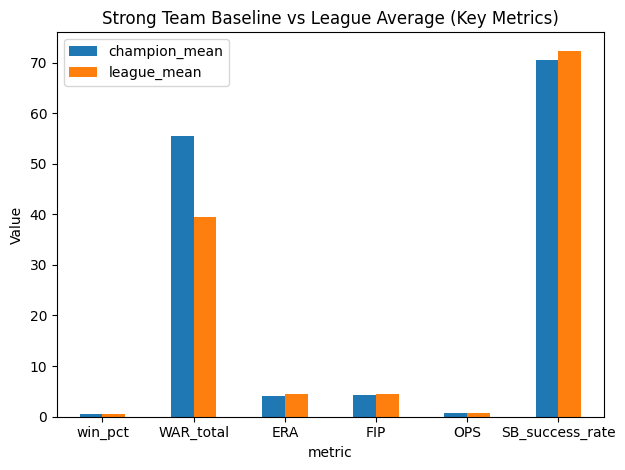

In [14]:
# 우승팀 평균 vs 리그 평균
key_metrics = ["win_pct","WAR_total","OPS","ERA","FIP","SB_success_rate"]
key_metrics = [m for m in key_metrics if m in baseline_table["metric"].values]

plot_df = (baseline_table[baseline_table["metric"].isin(key_metrics)]
           .set_index("metric")[["champion_mean","league_mean"]])

ax = plot_df.plot(kind="bar")
ax.set_title("Strong Team Baseline vs League Average (Key Metrics)")
ax.set_ylabel("Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


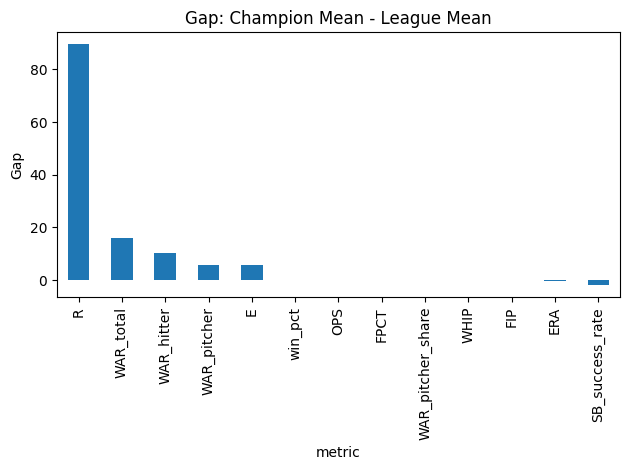

In [15]:
# 우승팀과 리그 간 차이
gap_df = (baseline_table.set_index("metric")["gap_vs_league"]
          .sort_values(ascending=False))

ax = gap_df.plot(kind="bar")
ax.set_title("Gap: Champion Mean - League Mean")
ax.set_ylabel("Gap")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
OUT_PATH = "../data/processed/master/kbo_season_master_2020_2025.csv"
df.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("Saved:", OUT_PATH)

Saved: ../data/processed/master/kbo_season_master_2020_2025.csv


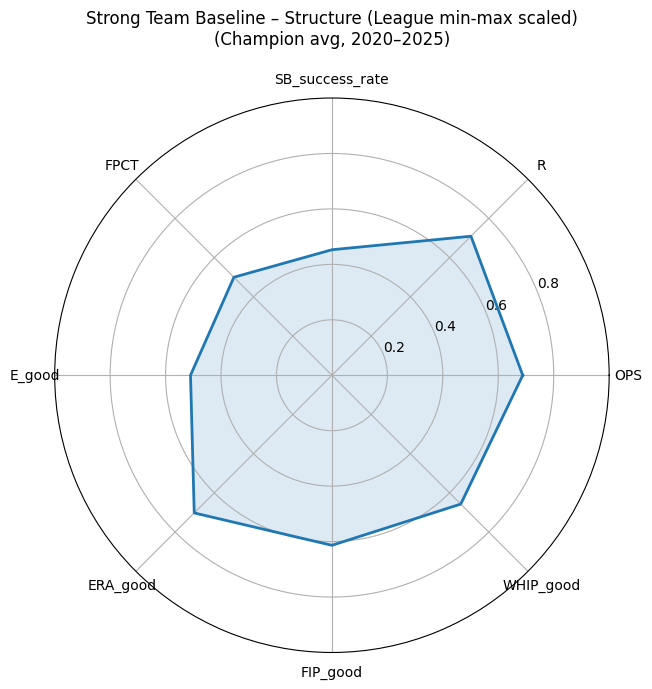

In [19]:
# 레이더 지표
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df: 마스터 로드 후 컬럼 표준화까지 끝난 데이터 (Year, rank, Team ...)

YEARS = [2020, 2021, 2022, 2023, 2024, 2025]
df5 = df[df["Year"].isin(YEARS)].copy()

# 1) 우승팀(=rank 1) baseline (연도별 1개씩, 총 5개 시즌)
champ = df5[df5["rank"] == 1].copy()

# 2) 레이더에 쓸 지표 구성 (마스터 버전)
#    - 높을수록 좋게 맞추기: ERA/FIP/WHIP/실책은 뒤집어서 "GOOD"로 변환
df5["ERA_good"]  = -df5["ERA"]
df5["FIP_good"]  = -df5["FIP"]
df5["WHIP_good"] = -df5["WHIP"]
df5["E_good"]    = -df5["E"]

champ["ERA_good"]  = -champ["ERA"]
champ["FIP_good"]  = -champ["FIP"]
champ["WHIP_good"] = -champ["WHIP"]
champ["E_good"]    = -champ["E"]

radar_metrics = [
    "OPS",            # 공격 퀄리티
    "R",              # 득점 생산
    "SB_success_rate",# 주루 효율
    "FPCT",           # 수비 안정성
    "E_good",         # 실책 적을수록 좋음(뒤집음)
    "ERA_good",       # 낮을수록 좋음(뒤집음)
    "FIP_good",       # 낮을수록 좋음(뒤집음)
    "WHIP_good"       # 낮을수록 좋음(뒤집음)
]

# 혹시 컬럼명이 다르면 여기서 radar_metrics만 너 df에 맞게 수정하면 됨.

# 3) League min-max scaling (2021-2025 리그 범위 기준)
mins = df5[radar_metrics].min(numeric_only=True)
maxs = df5[radar_metrics].max(numeric_only=True)

def minmax_scale(x):
    return (x - mins) / (maxs - mins).replace(0, np.nan)

# 4) 우승팀 baseline(평균) 스케일 값
baseline_raw = champ[radar_metrics].mean(numeric_only=True)
baseline_scaled = minmax_scale(baseline_raw).fillna(0).clip(0, 1)

# 5) Radar plot
labels = radar_metrics
values = baseline_scaled.values.tolist()
values += values[:1]  # 닫기

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(["0.2","0.4","0.6","0.8"])
ax.set_ylim(0, 1)

ax.set_title("Strong Team Baseline – Structure (League min-max scaled)\n(Champion avg, 2020–2025)", pad=20)
plt.tight_layout()
plt.show()
